# Time-MOE

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from transformers import AutoModelForCausalLM

from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS, TSMixer

from utilsforecast.losses import *
from utilsforecast.evaluation import evaluate

import warnings
warnings.filterwarnings("ignore")

os.environ["NIXTLA_ID_AS_COL"] = "true"
pd.set_option('display.precision', 3)

D:\Anaconda\envs\neuralforecast-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('data/medium_views_published_holidays.csv')
df['ds'] = pd.to_datetime(df['ds'])

df.head()

,unique_id,ds,y,published,is_holiday
0,0,2020-01-01,1131,0.0,1
1,0,2020-01-02,1764,0.0,0
2,0,2020-01-03,1699,0.0,0
3,0,2020-01-04,1322,0.0,0
4,0,2020-01-05,1491,0.0,0


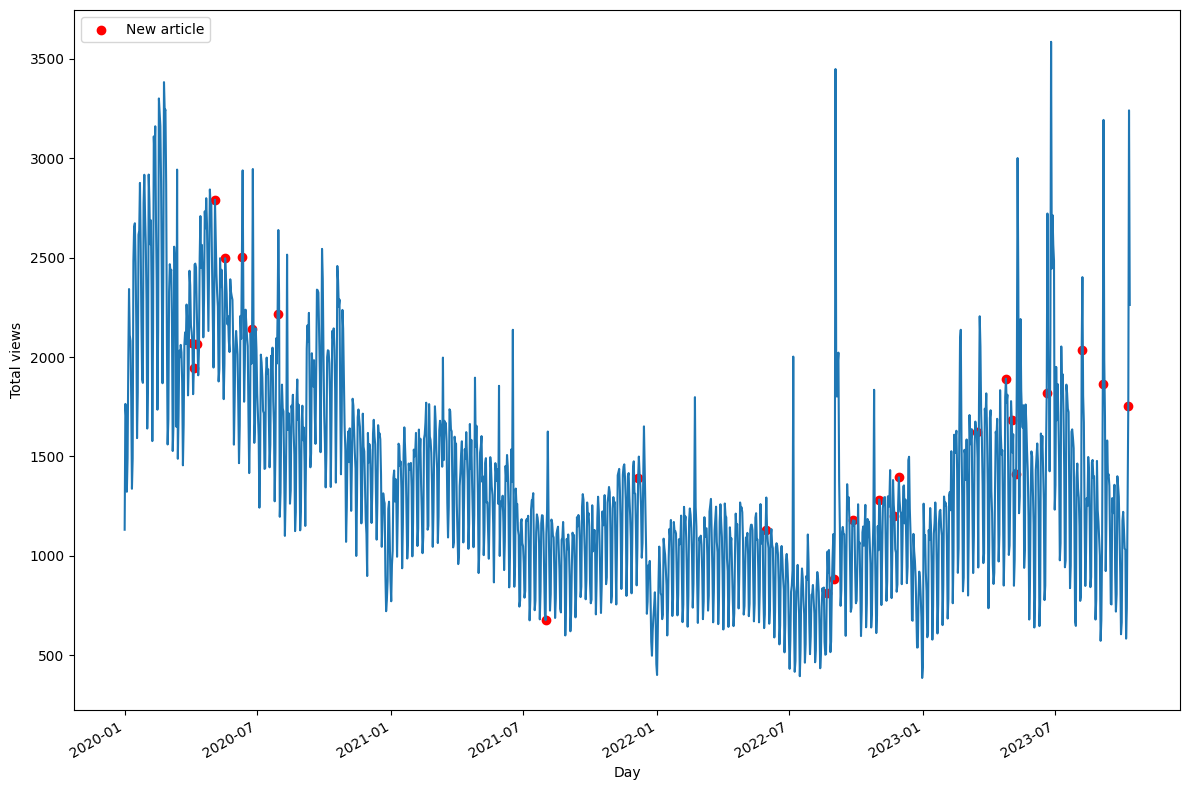

In [3]:
published_dates = df[df['published'] == 1]

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(df['ds'], df['y'])
ax.scatter(published_dates['ds'], published_dates['y'], marker='o', color='red', label='New article')
ax.set_xlabel('Day')
ax.set_ylabel('Total views')
ax.legend(loc='best')

fig.autofmt_xdate()
plt.tight_layout()

In [4]:
def timemoe_forecast(
    df,
    target_column,
    context_length,
    prediction_length,
    test_size,
    model_size='50M',
    device = 'cpu'
):
    data = torch.tensor(df[target_column].values, dtype=torch.float32)
    
    model = AutoModelForCausalLM.from_pretrained(
        f'Maple728/TimeMoE-{model_size}',
        device_map=device,
        trust_remote_code=True
    )
    
    all_predictions = []
    
    with torch.no_grad():
        for i in range(0, test_size - prediction_length + 1, prediction_length):
            # Get sequence for current window
            start_idx = len(data) - test_size + i - context_length
            sequence = data[start_idx:start_idx + context_length]
            sequence = sequence.unsqueeze(0)  # Add batch dimension
            
            # Normalize sequence
            mean = sequence.mean(dim=-1, keepdim=True)
            std = sequence.std(dim=-1, keepdim=True)
            normalized_sequence = (sequence - mean) / std
            
            # Generate forecast
            output = model.generate(
                normalized_sequence, 
                max_new_tokens=prediction_length
            )
            
            # Denormalize predictions
            normed_preds = output[:, -prediction_length:]
            predictions = normed_preds * std + mean
            all_predictions.append(predictions.squeeze(0))
    
    return torch.cat(all_predictions).numpy()

In [5]:
h = 7

timemoe_preds_50M = timemoe_forecast(
    df=df,
    target_column='y',
    context_length=6*h,
    prediction_length=h,
    test_size=168,
    device='cpu'
)

In [6]:
preds_df = df[-168:]
preds_df['Time-MOE'] = timemoe_preds_50M
preds_df.head()

,unique_id,ds,y,published,is_holiday,Time-MOE
1213,0,2023-04-28,1470,0.0,0,1399.965
1214,0,2023-04-29,1004,0.0,0,931.409
1215,0,2023-04-30,1051,0.0,0,1103.277
1216,0,2023-05-01,1333,0.0,0,1645.223
1217,0,2023-05-02,1778,0.0,0,1643.302


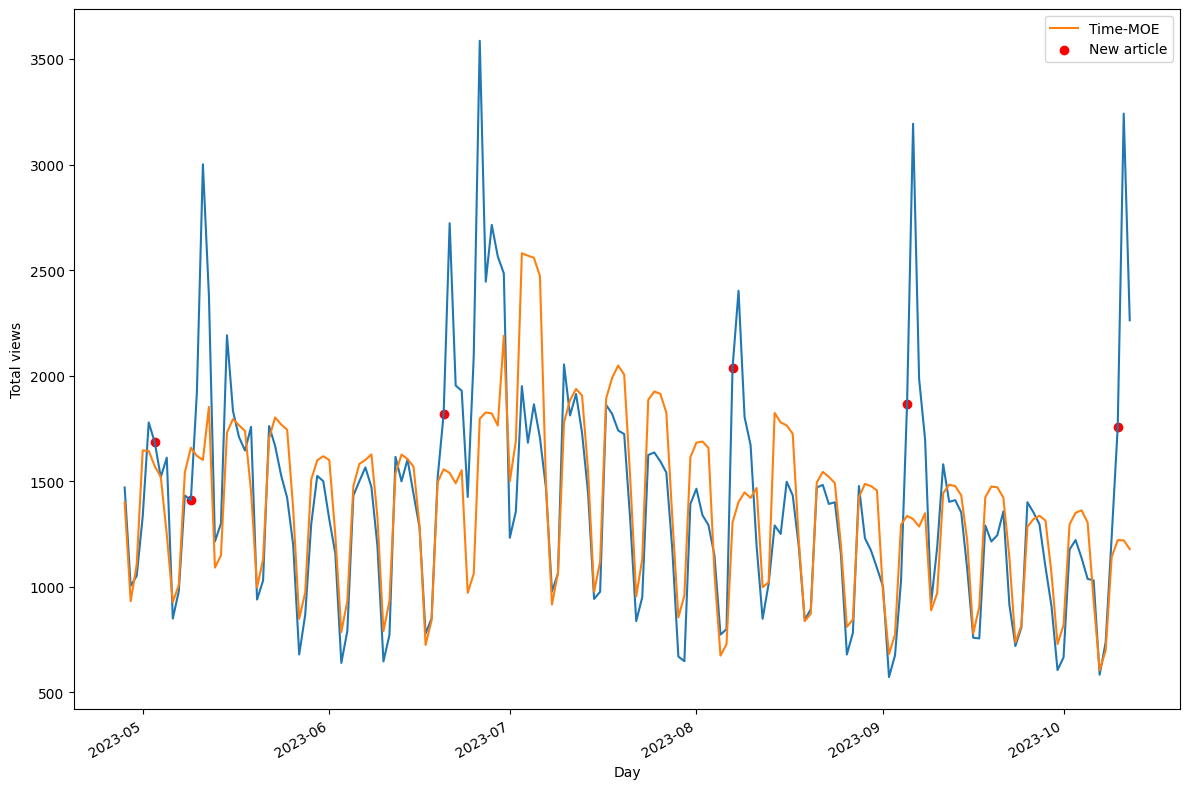

In [7]:
published_dates = preds_df[preds_df['published'] == 1]

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(preds_df['ds'], preds_df['y'])
ax.plot(preds_df['ds'], preds_df['Time-MOE'], label='Time-MOE')

ax.scatter(published_dates['ds'], published_dates['y'], marker='o', color='red', label='New article')

ax.set_xlabel('Day')
ax.set_ylabel('Total views')
ax.legend(loc='best')

fig.autofmt_xdate()

plt.tight_layout()

In [8]:
timemoe_preds_200M = timemoe_forecast(
    df=df,
    target_column='y',
    context_length=6*h,
    prediction_length=h,
    test_size=168,
    model_size='200M',
    device='cpu'
)

In [9]:
preds_df['Time-MOE-200M'] = timemoe_preds_200M
preds_df.head()

,unique_id,ds,y,published,is_holiday,Time-MOE,Time-MOE-200M
1213,0,2023-04-28,1470,0.0,0,1399.965,1488.232
1214,0,2023-04-29,1004,0.0,0,931.409,957.568
1215,0,2023-04-30,1051,0.0,0,1103.277,1107.564
1216,0,2023-05-01,1333,0.0,0,1645.223,1695.222
1217,0,2023-05-02,1778,0.0,0,1643.302,1668.735


## Data-specific models

In [10]:
models = [NHITS(h=h,
                input_size=5*h,
                max_steps=1000,
                early_stop_patience_steps=3,),
          TSMixer(h=h,
                  input_size=5*h,
                  n_series=1,
                  max_steps=1000,
                  early_stop_patience_steps=3)]

Global seed set to 1
Global seed set to 1


In [11]:
nf = NeuralForecast(models=models, freq='D')

cv_df = nf.cross_validation(
    df=df,
    step_size=h,
    val_size=168,
    test_size=168,
    n_windows=None
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.5 M 
-----------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.845     Total estimated model params size (MB)


Epoch 99: 100%|████████████████| 1/1 [00:00<00:00, 15.63it/s, v_num=129, train_loss_step=121.0, train_loss_epoch=124.0]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/1 [00:00<?, ?it/s]
Epoch 99: 100%|█| 1/1 [00:00<00:00,  9.26it/s, v_num=129, train_loss_step=121.0, train_loss_epoch=124.0, valid_loss=135
Epoch 199: 100%|█| 1/1 [00:00<00:00, 13.16it/s, v_num=129, train_loss_step=109.0, train_loss_epoch=108.0, valid_loss=13
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/1 [00:00<?, ?it/s]
Epoch 199: 100%|█| 1/1 [00:00<00:00,  9.01it/s, v_num=129, train_loss_step=109.0, train_loss_epoch=108.0, valid_loss=12
Epoch 299: 100%|█| 1/1 [00:00<00:00, 14.08it/s, v_num=129, train_loss_step=84.10, train_loss_epoch=85.50, valid_loss=12
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                     

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 142.88it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                     | Params
-----------------------------------------------------------
0 | loss          | MAE                      | 0     
1 | padder        | ConstantPad1d            | 0     
2 | scaler        | TemporalNorm             | 0     
3 | norm          | ReversibleInstanceNorm1d | 2     
4 | mixing_layers | Sequential               | 3.2 K 
5 | out           | Linear                   | 252   
-----------------------------------------------------------
3.4 K     Trainable params
0         Non-trainable params
3.4 K     Total params
0.014     Total estimated model params size (MB)



Epoch 99: 100%|████████████████| 1/1 [00:00<00:00, 71.44it/s, v_num=131, train_loss_step=284.0, train_loss_epoch=268.0]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/1 [00:00<?, ?it/s]
Epoch 99: 100%|█| 1/1 [00:00<00:00, 26.32it/s, v_num=131, train_loss_step=284.0, train_loss_epoch=268.0, valid_loss=226
Epoch 199: 100%|█| 1/1 [00:00<00:00, 66.68it/s, v_num=131, train_loss_step=206.0, train_loss_epoch=183.0, valid_loss=22
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/1 [00:00<?, ?it/s]
Epoch 199: 100%|█| 1/1 [00:00<00:00, 25.00it/s, v_num=131, train_loss_step=206.0, train_loss_epoch=183.0, valid_loss=18
Epoch 299: 100%|█| 1/1 [00:00<00:00, 90.92it/s, v_num=131, train_loss_step=181.0, train_loss_epoch=175.0, valid_loss=18
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                    

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|█| 1/1 [00:00<00:00, 25.64it/s, v_num=131, train_loss_step=138.0, train_loss_epoch=138.0, valid_loss=14


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 249.97it/s]


In [12]:
cv_df.head()

,unique_id,ds,cutoff,NHITS,TSMixer,y
0,0,2023-04-28,2023-04-27,1491.504,1377.311,1470
1,0,2023-04-29,2023-04-27,1025.147,1004.220,1004
2,0,2023-04-30,2023-04-27,1191.914,1163.555,1051
3,0,2023-05-01,2023-04-27,1856.258,1690.325,1333
4,0,2023-05-02,2023-04-27,1808.504,1800.577,1778


## Evaluation

In [13]:
cv_df['Time-MOE'] = preds_df['Time-MOE'].values
cv_df['Time-MOE-200M'] = preds_df['Time-MOE-200M'].values

cv_df.head()

,unique_id,ds,cutoff,NHITS,TSMixer,y,Time-MOE,Time-MOE-200M
0,0,2023-04-28,2023-04-27,1491.504,1377.311,1470,1399.965,1488.232
1,0,2023-04-29,2023-04-27,1025.147,1004.220,1004,931.409,957.568
2,0,2023-04-30,2023-04-27,1191.914,1163.555,1051,1103.277,1107.564
3,0,2023-05-01,2023-04-27,1856.258,1690.325,1333,1645.223,1695.222
4,0,2023-05-02,2023-04-27,1808.504,1800.577,1778,1643.302,1668.735


In [15]:
cv_df = cv_df.drop(['ds', 'cutoff'], axis=1)

evaluation = evaluate(
    cv_df,
    metrics=[mae, smape],
    target_col='y',
    id_col='unique_id'
)

evaluation

,unique_id,metric,NHITS,TSMixer,Time-MOE,Time-MOE-200M
0,0,mae,282.588,252.145,256.249,271.648
1,0,smape,0.094,0.080,0.082,0.088


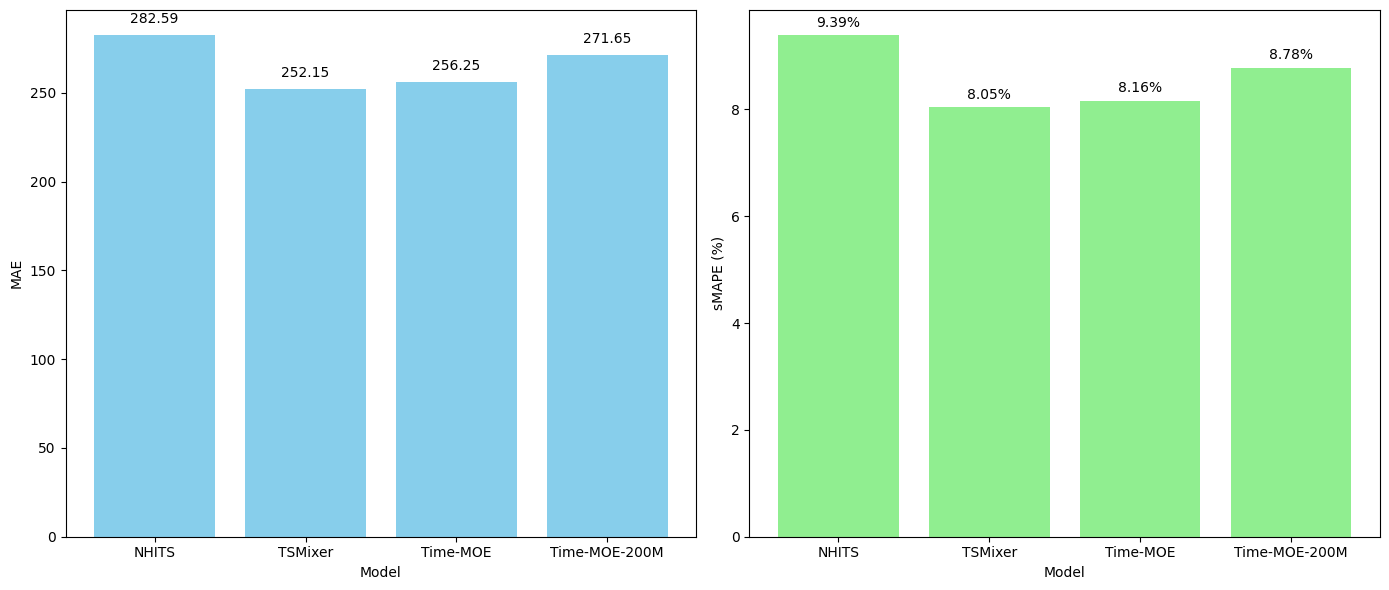

In [16]:
# Extract data for plotting
models = ['NHITS', 'TSMixer', 'Time-MOE', 'Time-MOE-200M']
mae_values = evaluation[evaluation['metric'] == 'mae'][models].values.flatten()
smape_values = evaluation[evaluation['metric'] == 'smape'][models].values.flatten() * 100  # Convert to percentage

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot for MAE
axes[0].bar(models, mae_values, color='skyblue')
axes[0].set_xlabel('Model')
axs[0].set_ylabel('MAE')

# Add value labels on top of the bars for MAE
for i, v in enumerate(mae_values):
    axes[0].text(i, v + 5, f'{v:.2f}', ha='center', va='bottom')

# Bar plot for sMAPE
axes[1].bar(models, smape_values, color='lightgreen')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('sMAPE (%)')

# Add value labels on top of the bars for sMAPE (as percentages)
for i, v in enumerate(smape_values):
    axes[1].text(i, v + 0.1, f'{v:.2f}%', ha='center', va='bottom')

# Adjust layout and display the plot
plt.tight_layout()